# Sentiment analysis 

### Imports

# New

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer

data_path = "../../data/txt_tp4/"
files = sorted([f for f in os.listdir(data_path) if f.endswith(".txt")])
texts = [open(os.path.join(data_path, f), "r", encoding="utf-8").read() for f in files]


In [2]:
def matches_query(text):
    txt = text.lower()
    cond1 = "sorcière" in txt or "sorciere" in txt
    cond2 = bool(re.search(r"\bfemm\w*|\bfémin\w*", txt))
    return cond1 and cond2

filtered = [(f, t) for f, t in zip(files, texts) if matches_query(t)]
print("Documents filtrés :", len(filtered))


Documents filtrés : 993


In [5]:
def sentiment_scores(text):
    blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    polarity, subjectivity = blob.sentiment
    return polarity, subjectivity

def extract_sentences(text):
    blob = TextBlob(text)
    return [str(sentence) for sentence in blob.sentences]

def contains_keywords(sentence):
    txt = sentence.lower()
    return "sorcière" in txt or "sorciere" in txt or re.search(r"\bfemm\w*|\bfémin\w*", txt)

sent_data = []

for fname, txt in filtered:  # Tous les documents filtrés uniquement par mots-clés
    sentences = extract_sentences(txt)
    for sent in sentences:
        if contains_keywords(sent):
            pol, subj = sentiment_scores(sent)
            sent_data.append([fname, sent, pol, subj])

df_sentences = pd.DataFrame(sent_data, columns=["fichier", "phrase", "polarity", "subjectivity"])
df_sentences.head()


,fichier,phrase,polarity,subjectivity
0,KB_JB838_1951-01-20_01-00005.txt,Quant au fond l’arrêt constate qu’il est établ...,-0.150000,-0.300000
1,KB_JB838_1951-01-20_01-00005.txt,"Les prévenus les extrayèrent du cachot, malgré...",0.200000,0.200000
2,KB_JB838_1951-01-20_01-00005.txt,Seul un rire sinistre de vieille sorcière lui ...,0.028333,0.225000
3,KB_JB838_1951-01-20_01-00005.txt,"Il n’hésitait pas à baiser la main des dames, ...",0.150000,0.000000
4,KB_JB838_1951-02-04_01-00020.txt,"La coupe est devenue sorcière, et plus rien n’...",0.000000,0.133333


In [6]:
def label_sentiment(p):
    if p > 0.1:
        return "positif"
    elif p < 0.08:
        return "négatif"
    else:
        return "neutre"

df_sentences["label"] = df_sentences["polarity"].apply(label_sentiment)
df_sentences["label"].value_counts()


label
négatif    3513
positif    1500
neutre      193
Name: count, dtype: int64

In [8]:
def extract_info(filename):
    name = filename.replace(".txt", "")
    parts = name.split("_")
    journal = parts[1] if len(parts) > 1 else None
    year = None
    if len(parts) > 2:
        match = re.match(r"(\d{4})-\d{2}-\d{2}", parts[2])
        if match:
            year = int(match.group(1))
    return journal, year

df_sentences["journal"], df_sentences["year"] = zip(*df_sentences["fichier"].apply(extract_info))


In [ ]:
df_sentences.to_csv("sentiment_analysis_phrases_all_docs.csv", index=False)


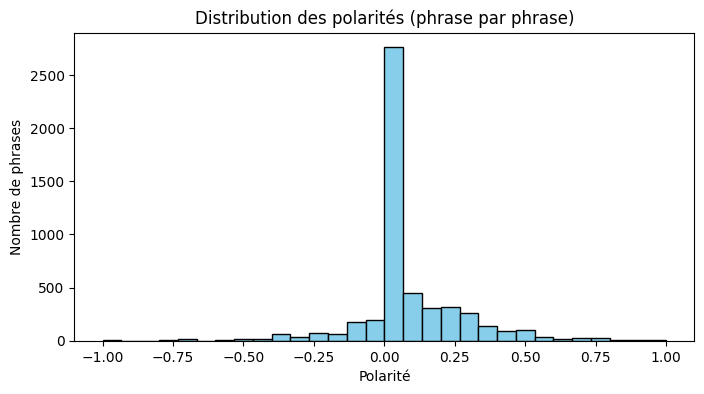

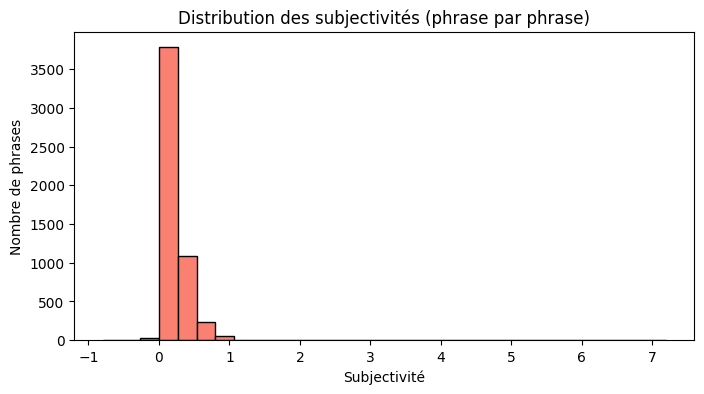

In [9]:
# Distribution des polaritées et subjectivitées
# Histogramme polarité
plt.figure(figsize=(8,4))
plt.hist(df_sentences["polarity"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution des polarités (phrase par phrase)")
plt.xlabel("Polarité")
plt.ylabel("Nombre de phrases")
plt.show()

# Histogramme subjectivité
plt.figure(figsize=(8,4))
plt.hist(df_sentences["subjectivity"], bins=30, color="salmon", edgecolor="black")
plt.title("Distribution des subjectivités (phrase par phrase)")
plt.xlabel("Subjectivité")
plt.ylabel("Nombre de phrases")
plt.show()


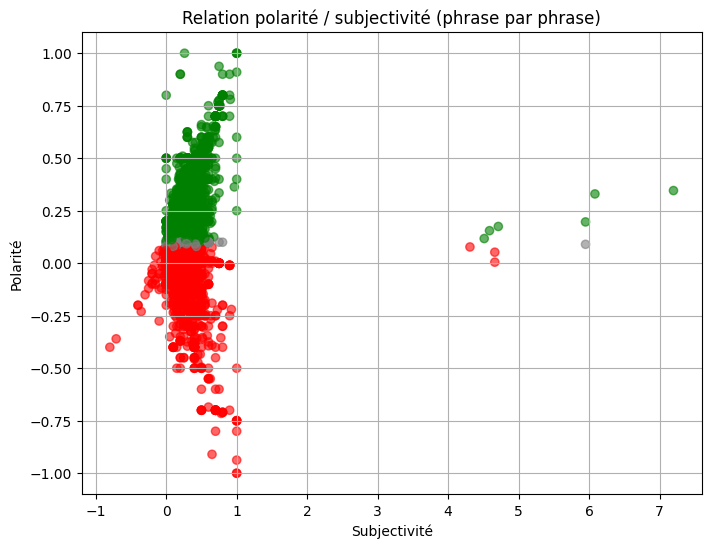

In [10]:
# Scatter polarité / subjectivitées avec labels
plt.figure(figsize=(8,6))
colors = df_sentences["label"].map({"positif":"green","neutre":"gray","négatif":"red"})
plt.scatter(df_sentences["subjectivity"], df_sentences["polarity"], c=colors, alpha=0.6)
plt.xlabel("Subjectivité")
plt.ylabel("Polarité")
plt.title("Relation polarité / subjectivité (phrase par phrase)")
plt.grid(True)
plt.show()


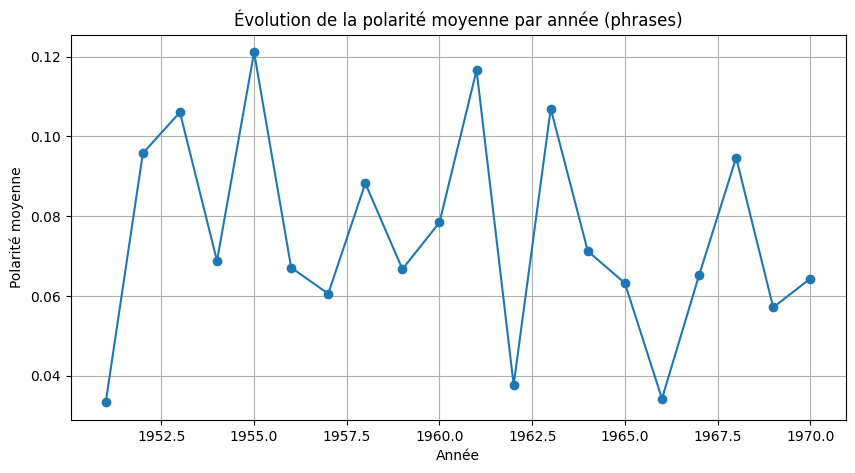

In [11]:
# Evolution de la polartié moyene par année
df_year_clean = df_sentences.dropna(subset=["year"])
df_year = df_year_clean.groupby("year")["polarity"].mean().sort_index()

plt.figure(figsize=(10,5))
plt.plot(df_year.index, df_year.values, marker='o', linestyle='-')
plt.title("Évolution de la polarité moyenne par année (phrases)")
plt.xlabel("Année")
plt.ylabel("Polarité moyenne")
plt.grid(True)
plt.show()


In [12]:
#Top phrases les plus positives

In [13]:
print("Top 10 phrases les plus positives :")
print(df_sentences.sort_values("polarity", ascending=False).head(10)[["fichier","phrase","polarity","subjectivity","label"]])

print("\nTop 10 phrases les plus négatives :")
print(df_sentences.sort_values("polarity", ascending=True).head(10)[["fichier","phrase","polarity","subjectivity","label"]])


Top 10 phrases les plus positives :
                               fichier  \
4161  KB_JB838_1967-06-25_01-00006.txt   
1466  KB_JB838_1956-12-19_01-00012.txt   
3376  KB_JB838_1966-01-28_01-00008.txt   
2876  KB_JB838_1963-06-29_01-00011.txt   
850   KB_JB838_1954-12-23_01-00011.txt   
1183  KB_JB838_1956-07-20_01-00013.txt   
4687  KB_JB838_1969-09-02_01-00008.txt   
945   KB_JB838_1955-07-03_01-00014.txt   
2292  KB_JB838_1960-09-21_01-00009.txt   
4147  KB_JB838_1967-06-04_01-00030.txt   

                                                 phrase  polarity  \
4161  ’ — Mademoiselle Agarra, permettez-moi de vous...    1.0000   
1466  .Venez dès aujourd’hui essayer et choisir votr...    1.0000   
3376  Dans le magnifique décor d’une cathédrale en c...    1.0000   
2876  Quant à ses femmes, Catherine d’Aragon apparaî...    1.0000   
850   /wwwv vwwwvs n/IHI IFR P r - e » 33-24 (Réveil...    0.9375   
1183  l’Alexandre Dumas 73250 1 (Porte de Namur) LA ...    0.9100   
4687  Comment une 

In [15]:
# Statistique globale
# Statistiques descriptives
stats_globales = df_sentences[["polarity", "subjectivity"]].describe()
print(stats_globales)


          polarity  subjectivity
count  5206.000000   5206.000000
mean      0.068367      0.167735
std       0.191579      0.303214
min      -1.000000     -0.800000
25%       0.000000      0.000000
50%       0.000000      0.100000
75%       0.135000      0.280000
max       1.000000      7.198000
